In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from pandas.plotting import scatter_matrix
from utilities import clip_outliers
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from scipy.stats import kstest
from scipy.stats import pointbiserialr
from scipy.stats import ttest_rel
from sklearn.feature_selection import f_classif
import numpy as np
from sklearn.decomposition import PCA

# Data Analysis: Soybean Cultivars

The Soybean Cultivars dataset provides features including plant height, insertion of the first pod, number of stems, number of legumes per plant, number of grains per plant, number of grains per pod/per plant, thousand seed weight, and grain yield of soyplant gathered during an experiment.

For additional information about the dataset and how the experiment was conducted, please refer to [this link](https://editorapantanal.com.br/journal/index.php/taes/article/view/8/5).

![Soyplant](soyplant.jpg)

After reviewing the dataset documentation and researching the appearance of soyplants, several assumptions can be made about the variables:

- The number of legumes per plant multiplied by the number of grains per pod should be equal to the number of grains per plant.
- There might be a correlation between plant height, the number of legumes per plant, and the insertion of the first pod.
- The number of stems may be correlated with the aforementioned factors.

Our initial focus will be on employing statistical methods and visual exploration to gain deeper insights into the data and its correlations. Subsequently, we'll explore methods for generating a new cultivar.
đ

In [3]:
data = pd.read_csv('data/data.csv')

# Data exploration

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Season      320 non-null    int64  
 1   Cultivar    320 non-null    object 
 2   Repetition  320 non-null    int64  
 3   PH          320 non-null    float64
 4   IFP         320 non-null    float64
 5   NLP         320 non-null    float64
 6   NGP         320 non-null    float64
 7   NGL         320 non-null    float64
 8   NS          320 non-null    float64
 9   MHG         320 non-null    float64
 10  GY          320 non-null    float64
dtypes: float64(8), int64(2), object(1)
memory usage: 27.6+ KB


As stated in the dataset documentation there are no missing values and all the columns have the right data type.

In [5]:
data.describe()

,Season,Repetition,PH,IFP,NLP,NGP,NGL,NS,MHG,GY
count,320.000000,320.000000,320.000000,320.0000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000
mean,1.500000,2.500000,68.386781,15.4650,59.088313,135.085844,2.290844,4.071656,168.322313,3418.553794
std,0.500783,1.119785,8.958194,3.0243,20.068187,60.494529,0.840116,1.474531,19.625566,503.003602
min,1.000000,1.000000,47.600000,7.2000,20.200000,47.800000,0.940000,0.400000,127.060000,1538.230000
25%,1.000000,1.750000,62.950000,13.6000,44.350000,95.052500,2.000000,3.000000,153.845000,3126.611552
50%,1.500000,2.500000,67.200000,15.6000,54.500000,123.000000,2.280000,3.800000,166.150000,3397.276724
75%,2.000000,3.250000,74.347500,17.3300,71.220000,161.350000,2.480000,5.000000,183.182500,3708.262931
max,2.000000,4.000000,94.800000,26.4000,123.000000,683.400000,14.860000,9.000000,216.000000,4930.000000


Looking at number of grains per plant (NGP) we can see that the mean (sensitive to outliers) is significantly greater than the median, the same for number of legumes per plant (NLP).

In [7]:
float_cols = data.select_dtypes(include='float64').columns

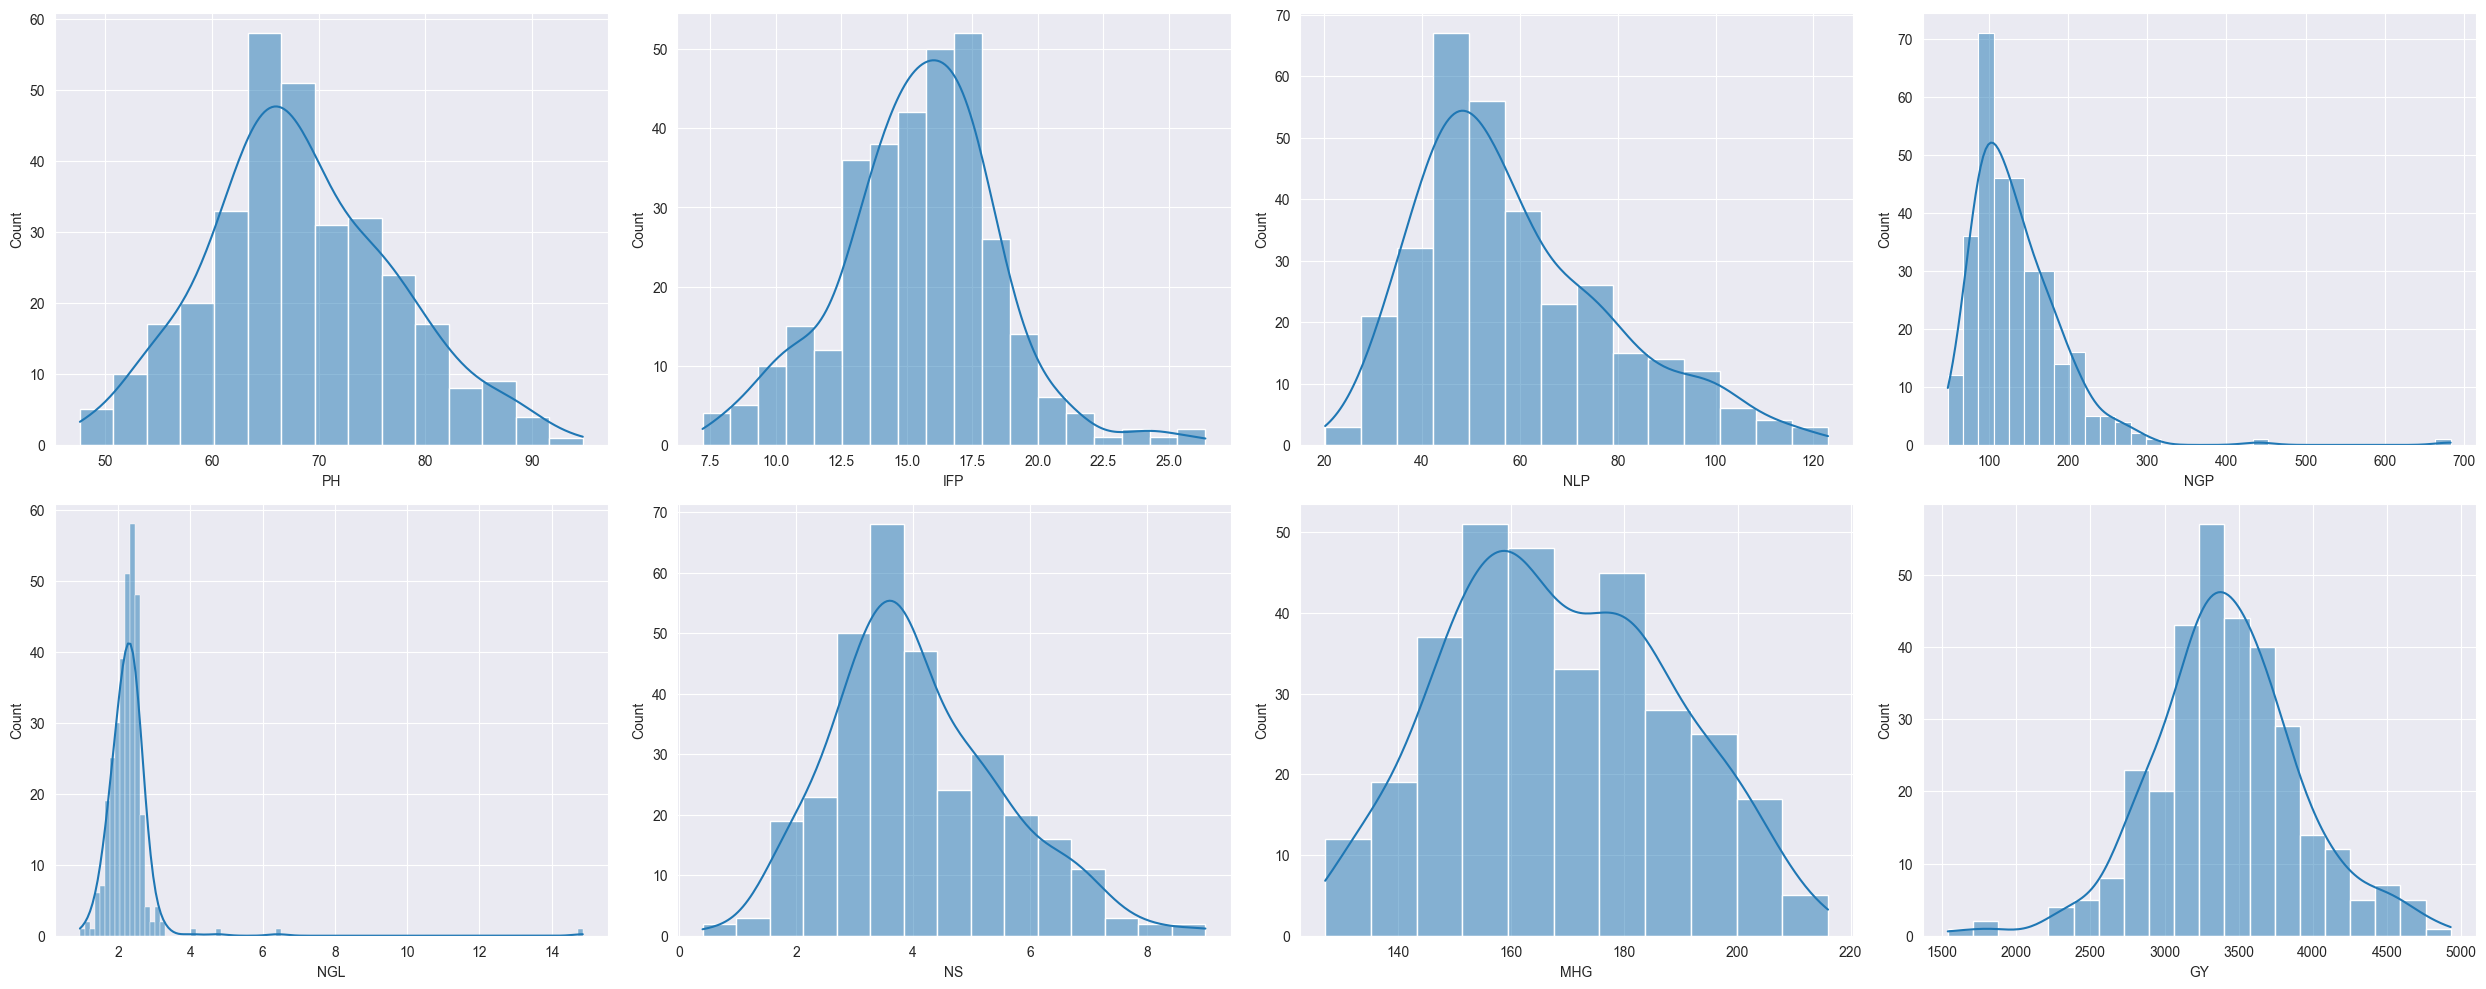

In [12]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(25,10))
cnt = 0
for i in range(2):
    for j in range(4):
        sns.histplot(data[float_cols.tolist()[cnt]], ax=axs[i,j], kde=True)
        cnt += 1
fig.tight_layout()
plt.show()

We can see that the number of grains per legume (NGL), the number of grains per plant (NGP) and IFP have a long positive tail, MHG has 2 peaks. GY have as well a negative tail. Further segmentation investigation needs to be done. There are some soy plants that have a lot of legumes therefore they have a lot of grains.

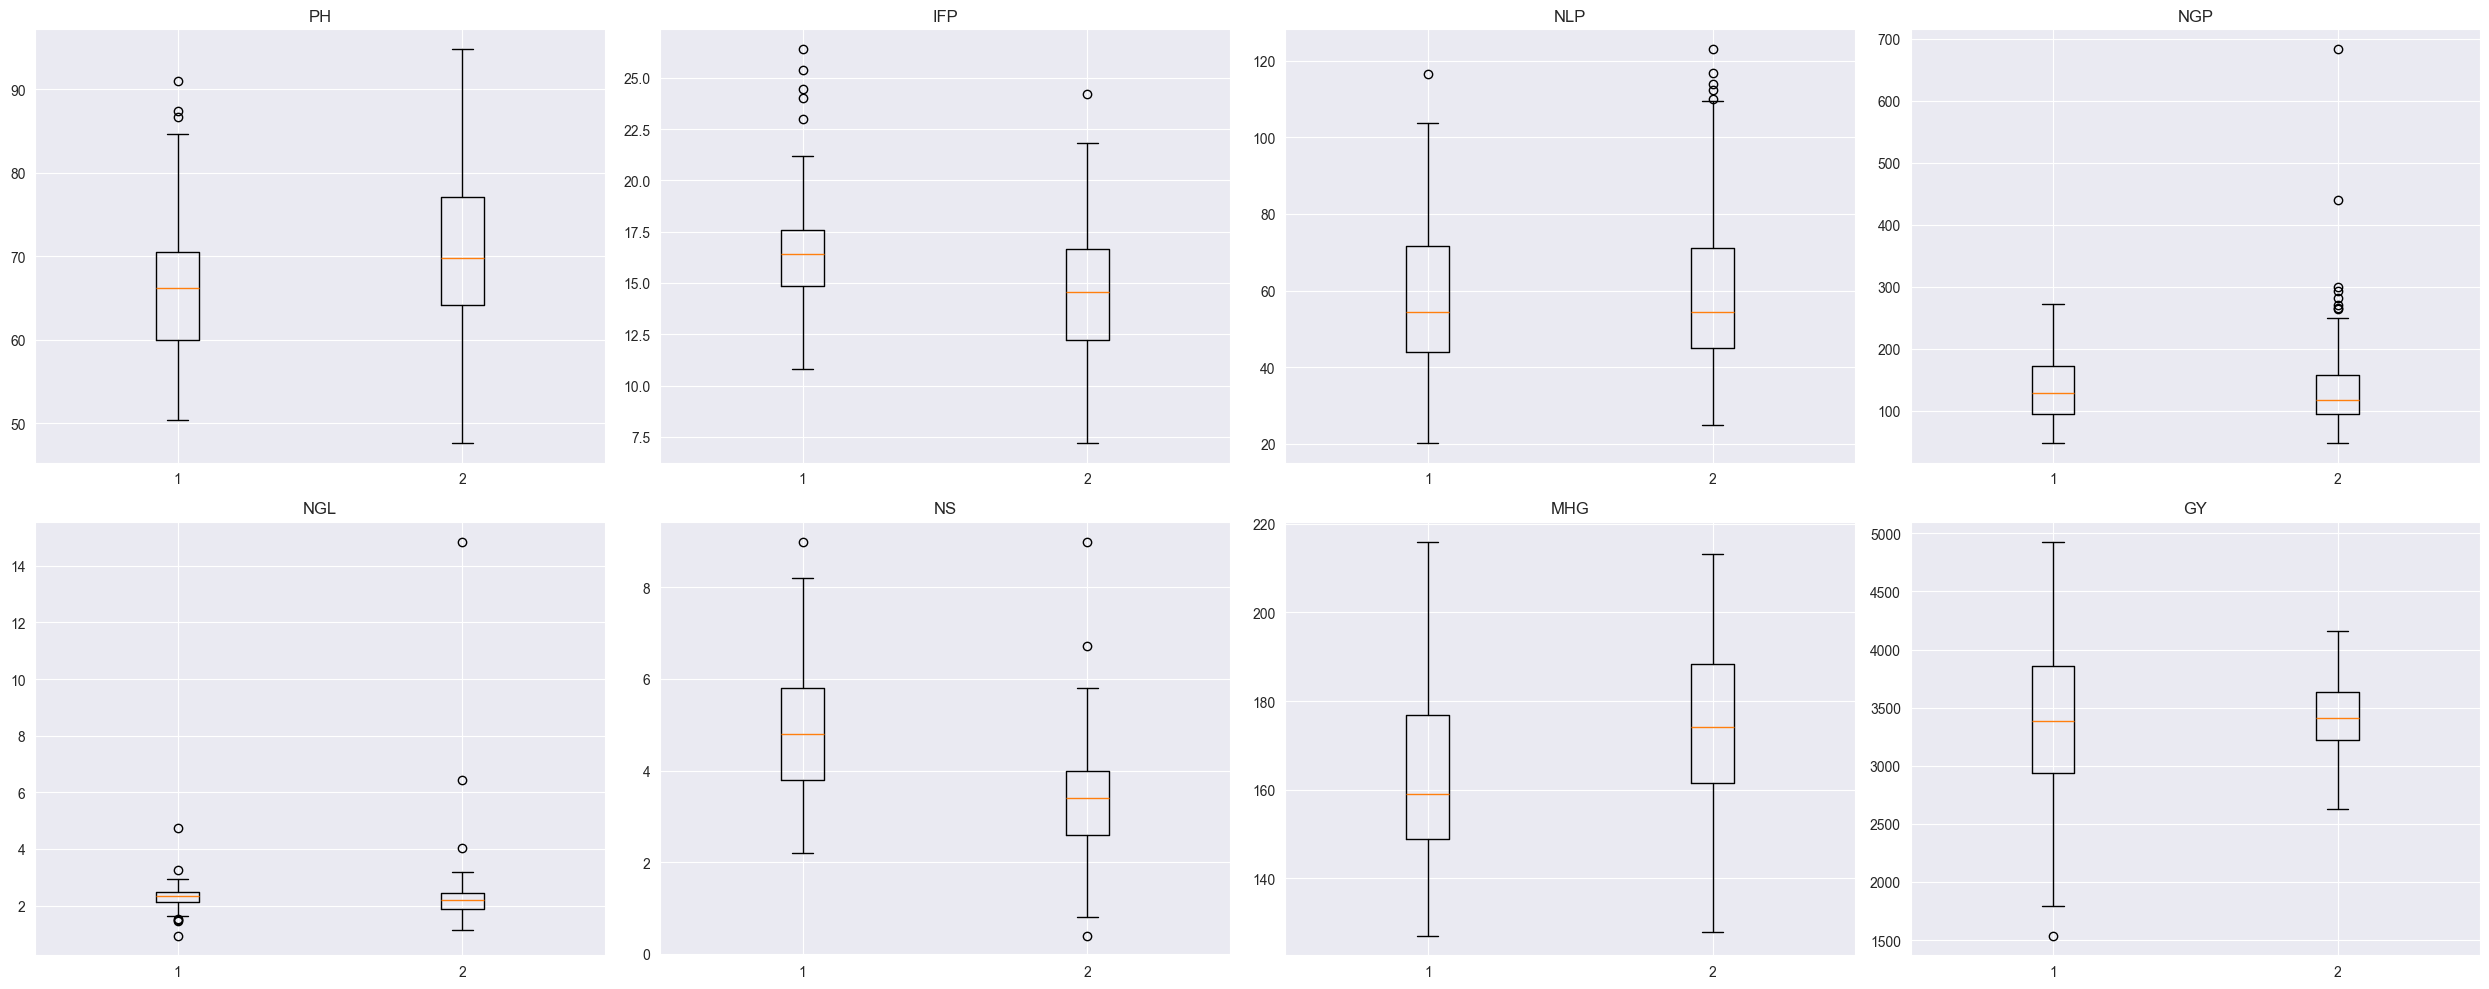

In [16]:
season1 = data[data.Season == 1]
season2 = data[data.Season == 2]
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(25,10))
cnt = 0
for i in range(2):
    for j in range(4):
        axs[i, j].boxplot([season1[float_cols.tolist()[cnt]], season2[float_cols.tolist()[cnt]]])
        axs[i, j].set_title(float_cols.tolist()[cnt])
        cnt += 1
fig.tight_layout()
plt.show()

If we split by season we observe that in general the plants from season 2 are taller, but the insertion of the first pod in lower and although they have less stems they roughly have the same number of grains. We can also think that there is a slight negative correlation between PH and NS when splitted by season, also lets take a look at distributions.

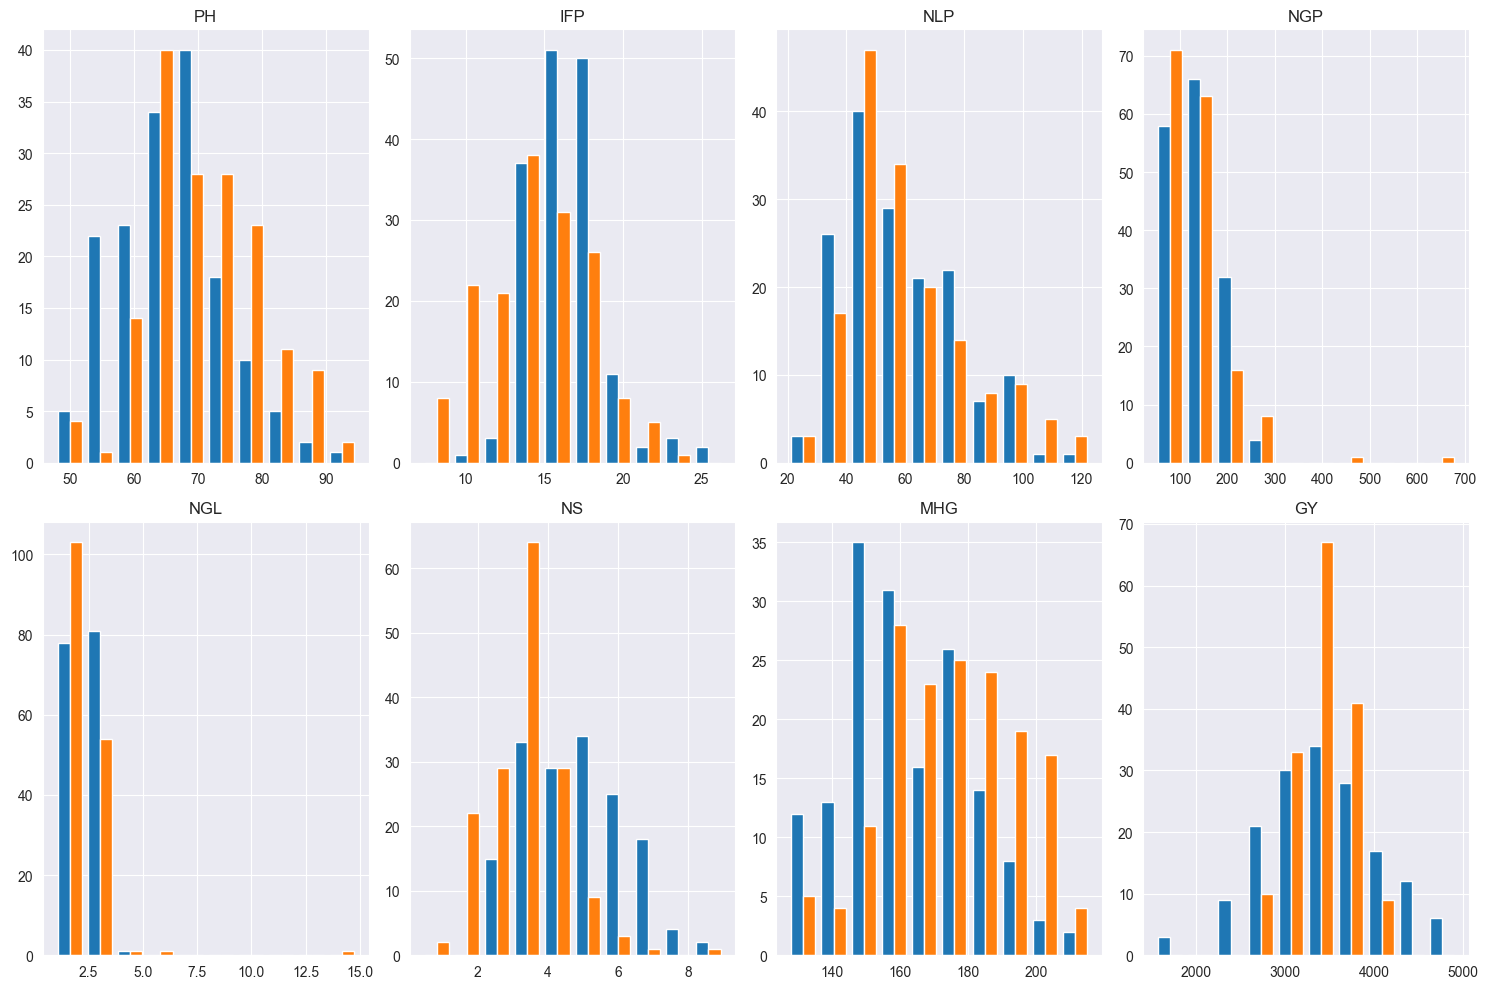

In [17]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(15,10))
cnt = 0
for i in range(2):
    for j in range(4):
        axs[i, j].hist([season1[float_cols.tolist()[cnt]], season2[float_cols.tolist()[cnt]]])
        axs[i, j].set_title(float_cols.tolist()[cnt])
        cnt += 1
fig.tight_layout()
plt.show()

Further statistical tests needs to be done in order to determine if the season have a significant importance. But, for now, let's check for correlations.

C:\Users\Cata\AppData\Local\Temp\ipykernel_18508\54100882.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  scatter_matrix(data.select_dtypes(exclude='object'), ax=ax)


array([[<Axes: xlabel='Season', ylabel='Season'>,
        <Axes: xlabel='Repetition', ylabel='Season'>,
        <Axes: xlabel='PH', ylabel='Season'>,
        <Axes: xlabel='IFP', ylabel='Season'>,
        <Axes: xlabel='NLP', ylabel='Season'>,
        <Axes: xlabel='NGP', ylabel='Season'>,
        <Axes: xlabel='NGL', ylabel='Season'>,
        <Axes: xlabel='NS', ylabel='Season'>,
        <Axes: xlabel='MHG', ylabel='Season'>,
        <Axes: xlabel='GY', ylabel='Season'>],
       [<Axes: xlabel='Season', ylabel='Repetition'>,
        <Axes: xlabel='Repetition', ylabel='Repetition'>,
        <Axes: xlabel='PH', ylabel='Repetition'>,
        <Axes: xlabel='IFP', ylabel='Repetition'>,
        <Axes: xlabel='NLP', ylabel='Repetition'>,
        <Axes: xlabel='NGP', ylabel='Repetition'>,
        <Axes: xlabel='NGL', ylabel='Repetition'>,
        <Axes: xlabel='NS', ylabel='Repetition'>,
        <Axes: xlabel='MHG', ylabel='Repetition'>,
        <Axes: xlabel='GY', ylabel='Repetition'>],
    

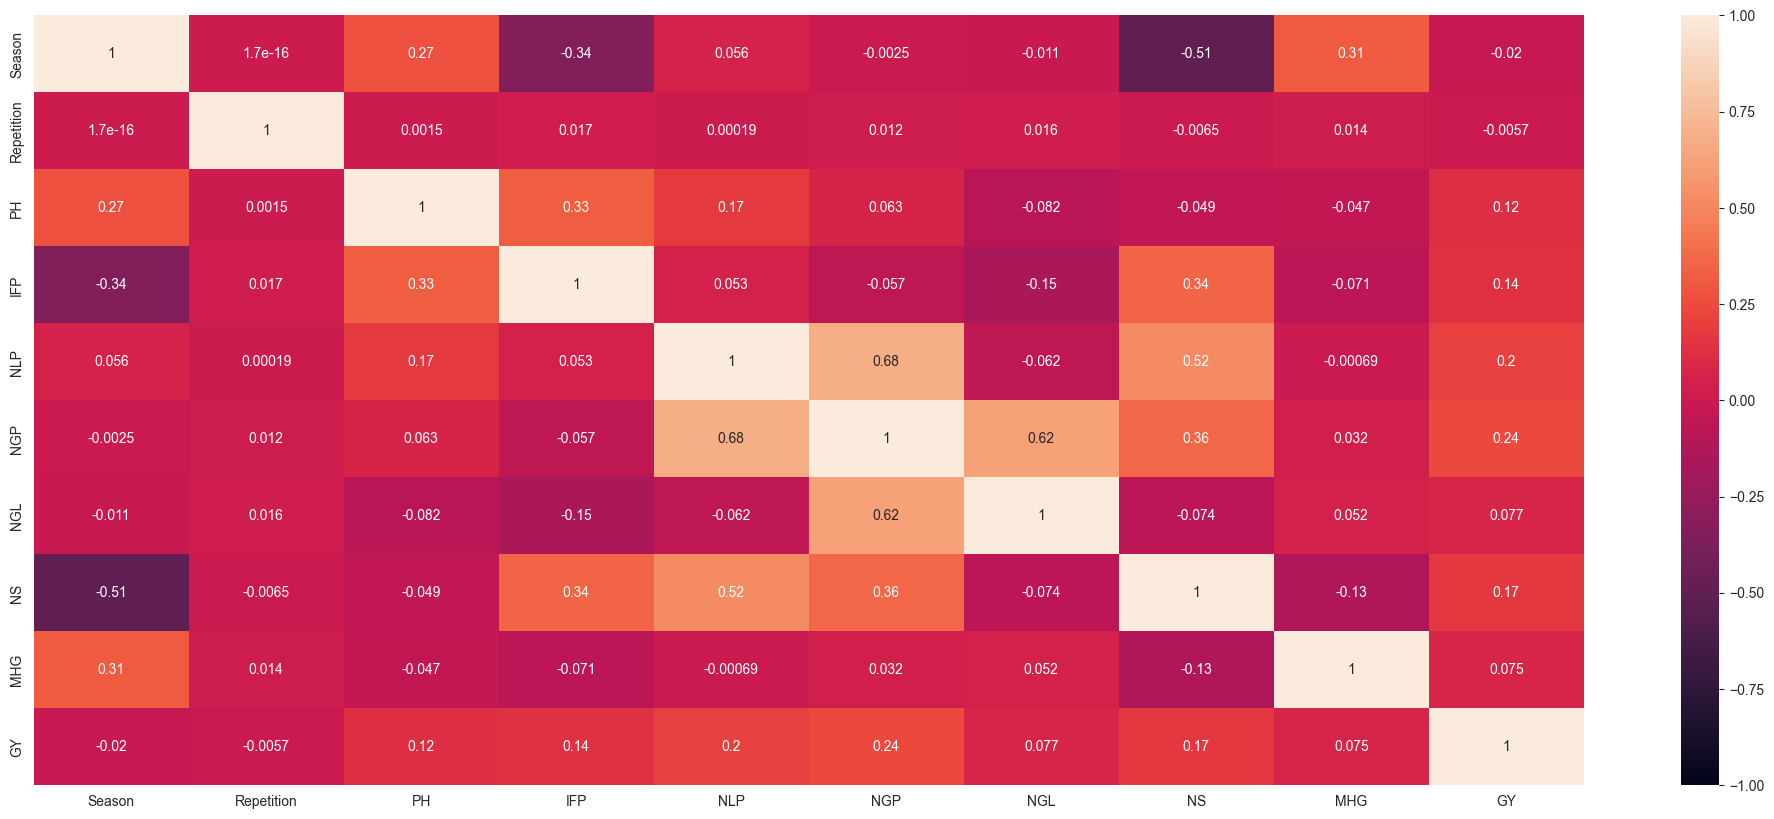

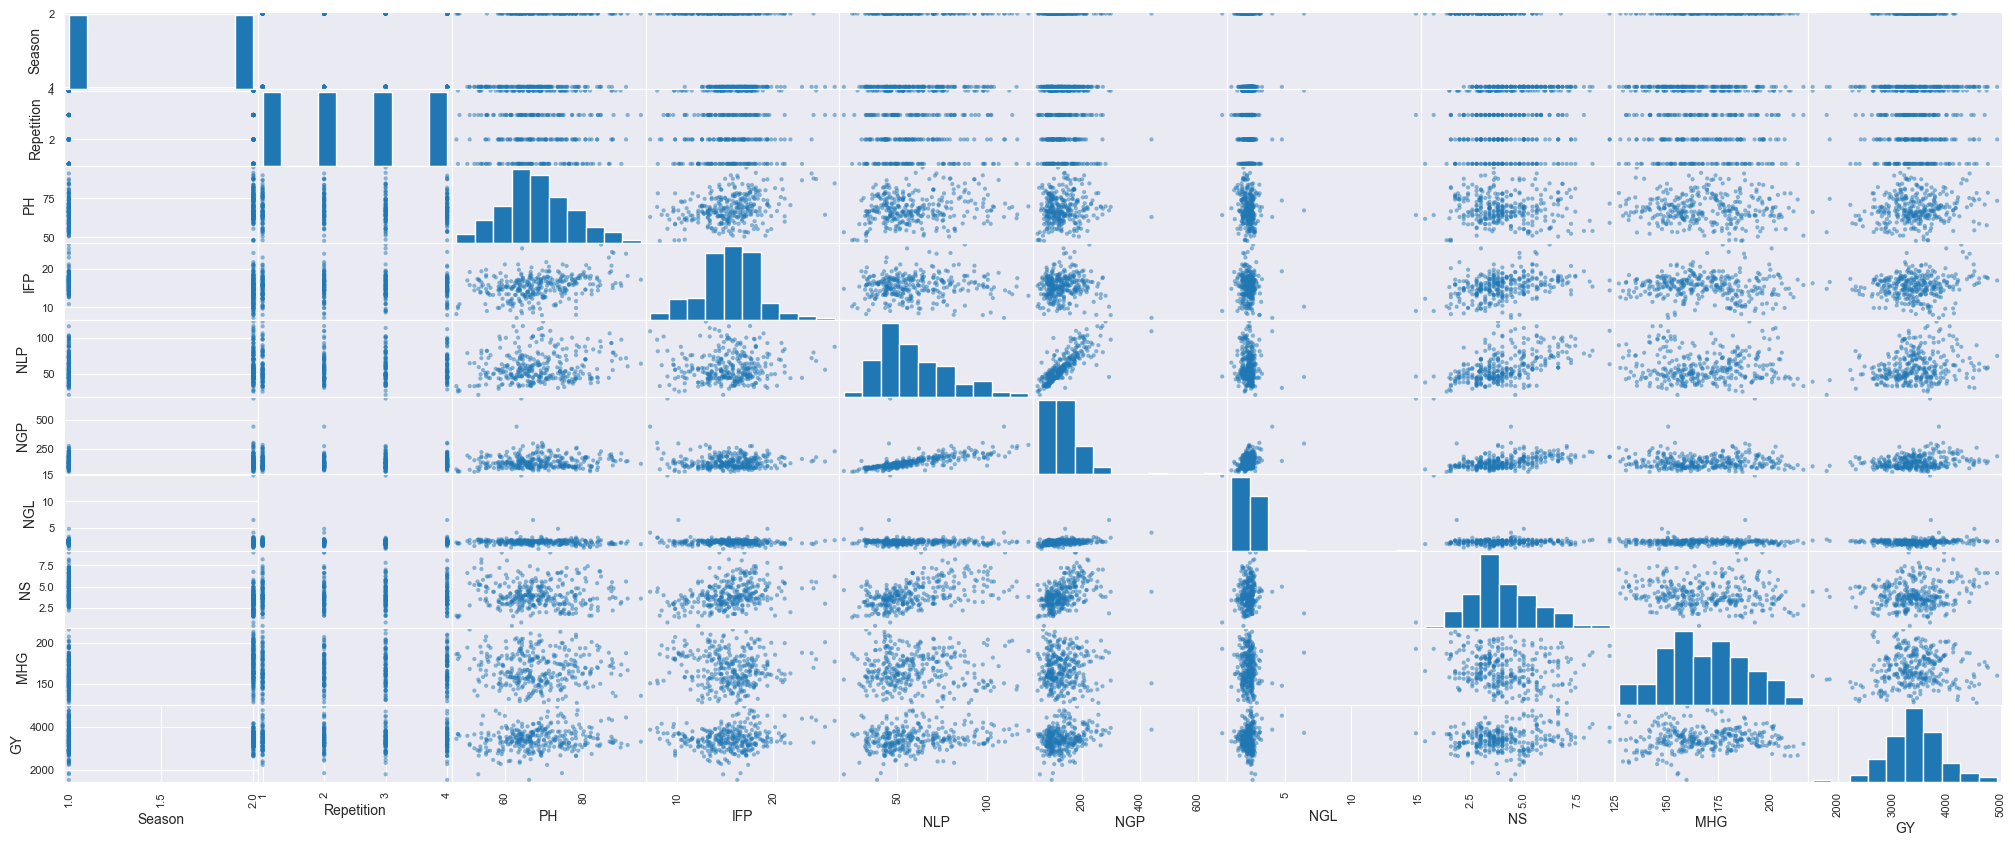

In [41]:
fig, ax = plt.subplots(1, figsize=(25,10))
sns.heatmap(data.select_dtypes(exclude='object').corr(), annot=True, vmin=-1, vmax=1)
fig, ax = plt.subplots(1, figsize=(25,10))
scatter_matrix(data.select_dtypes(exclude='object'), ax=ax)

Looking at the above plots we can derive the followings:
<li> There is a moderate linear negative relationship between season and number of stems. </li>
<li> Also season have weak correlations with IFP, PH, MHG. I'm guessing that one season is more potent than the other.</li>
<li> There is  a weak correlation between plant height and insertion of the first pod, I think that if a plant is taller, its first pod will be ata higher level.</li>
<li> As stated in the beggining there is a fairly strong positive correlation between the number of grains per plant (NGP), number of grain per legume (NGP), number of legumes per plant(NLP) and number of stems. The more stems <=> the more grains and so on. The actual causation needs to be determined</li>
<li>At first glance the repetion its not corelated with anything as it should.</li>

We need to gain more information in order to conclude if there is any causation or if a variable influences another variable.

Next I want to see of there's a statistical difference between the two different seasons, so I will apply a z tes. Furthermore we may check the distribution for each season and each distribution.

In [11]:
cnt = 0
for i in range(2):
    for j in range(4):
        ttest = ttest_rel(season1[float_cols.tolist()[cnt]], season2[float_cols.tolist()[cnt]])
        print(ttest, ttest.pvalue < 0.05, float_cols.tolist()[cnt])
        cnt += 1

TtestResult(statistic=-5.223377518527775, pvalue=5.436941032725221e-07, df=159) True PH
TtestResult(statistic=6.200349685087187, pvalue=4.661860028470372e-09, df=159) True IFP
TtestResult(statistic=-0.9345342545825952, pvalue=0.35144547225531764, df=159) False NLP
TtestResult(statistic=0.04495588294260384, pvalue=0.9641988845514012, df=159) False NGP
TtestResult(statistic=0.1865096555166533, pvalue=0.852282861982718, df=159) False NGL
TtestResult(statistic=9.988465763521944, pvalue=1.5410101405697554e-18, df=159) True NS
TtestResult(statistic=-11.976122254388178, pvalue=5.771530786320228e-24, df=159) True MHG
TtestResult(statistic=0.3579641049580847, pvalue=0.7208449414846438, df=159) False GY


So the season is an important factor for MHG.

In [36]:
pb = pointbiserialr(data['Season'], data['MHG'])
print(pb, pb.pvalue < 0.05)
print(np.corrcoef(data['Season'], data['MHG']))

SignificanceResult(statistic=0.3079121134632343, pvalue=1.8684169992354057e-08) True
[[1.         0.30791211]
 [0.30791211 1.        ]]


So we can conclude that the season is an important factor for MHG, due to the low pvalue.

In [47]:
pb = pointbiserialr(data['Season'], data['NS'])
print(pb, pb.pvalue < 0.05)
print(np.corrcoef(data['Season'], data['NS']))

SignificanceResult(statistic=-0.5060155700131118, pvalue=3.293487301480424e-22) True
[[ 1.         -0.50601557]
 [-0.50601557  1.        ]]


Season is as well an important factor for NS.

<Axes: >

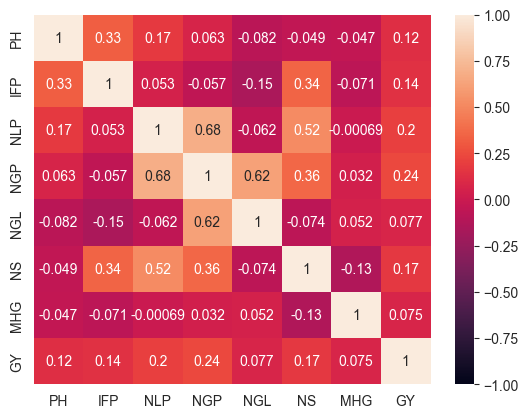

In [9]:
sns.heatmap(data[float_cols].corr(), annot=True, vmin=-1, vmax=1)

<Axes: >

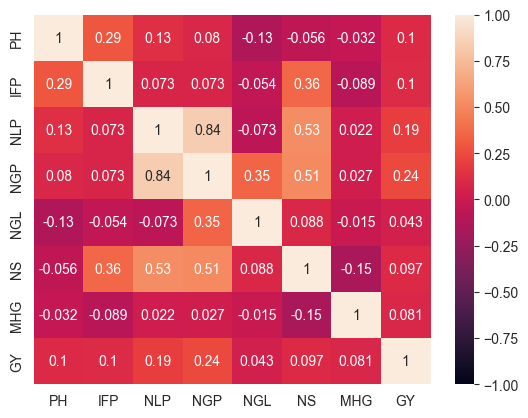

In [5]:
sns.heatmap(data[float_cols].corr(method='spearman'), annot=True, vmin=-1, vmax=1)

<Axes: >

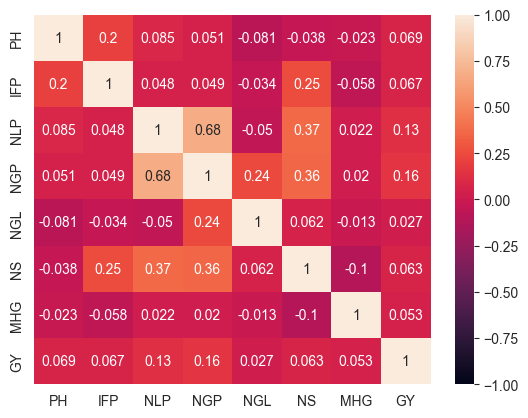

In [8]:
sns.heatmap(data[float_cols].corr(method='kendall'), annot=True, vmin=-1, vmax=1)

array([[<Axes: xlabel='PH', ylabel='PH'>,
        <Axes: xlabel='IFP', ylabel='PH'>,
        <Axes: xlabel='NLP', ylabel='PH'>,
        <Axes: xlabel='NGP', ylabel='PH'>,
        <Axes: xlabel='NGL', ylabel='PH'>,
        <Axes: xlabel='NS', ylabel='PH'>,
        <Axes: xlabel='MHG', ylabel='PH'>,
        <Axes: xlabel='GY', ylabel='PH'>],
       [<Axes: xlabel='PH', ylabel='IFP'>,
        <Axes: xlabel='IFP', ylabel='IFP'>,
        <Axes: xlabel='NLP', ylabel='IFP'>,
        <Axes: xlabel='NGP', ylabel='IFP'>,
        <Axes: xlabel='NGL', ylabel='IFP'>,
        <Axes: xlabel='NS', ylabel='IFP'>,
        <Axes: xlabel='MHG', ylabel='IFP'>,
        <Axes: xlabel='GY', ylabel='IFP'>],
       [<Axes: xlabel='PH', ylabel='NLP'>,
        <Axes: xlabel='IFP', ylabel='NLP'>,
        <Axes: xlabel='NLP', ylabel='NLP'>,
        <Axes: xlabel='NGP', ylabel='NLP'>,
        <Axes: xlabel='NGL', ylabel='NLP'>,
        <Axes: xlabel='NS', ylabel='NLP'>,
        <Axes: xlabel='MHG', ylabel='NLP'>,
  

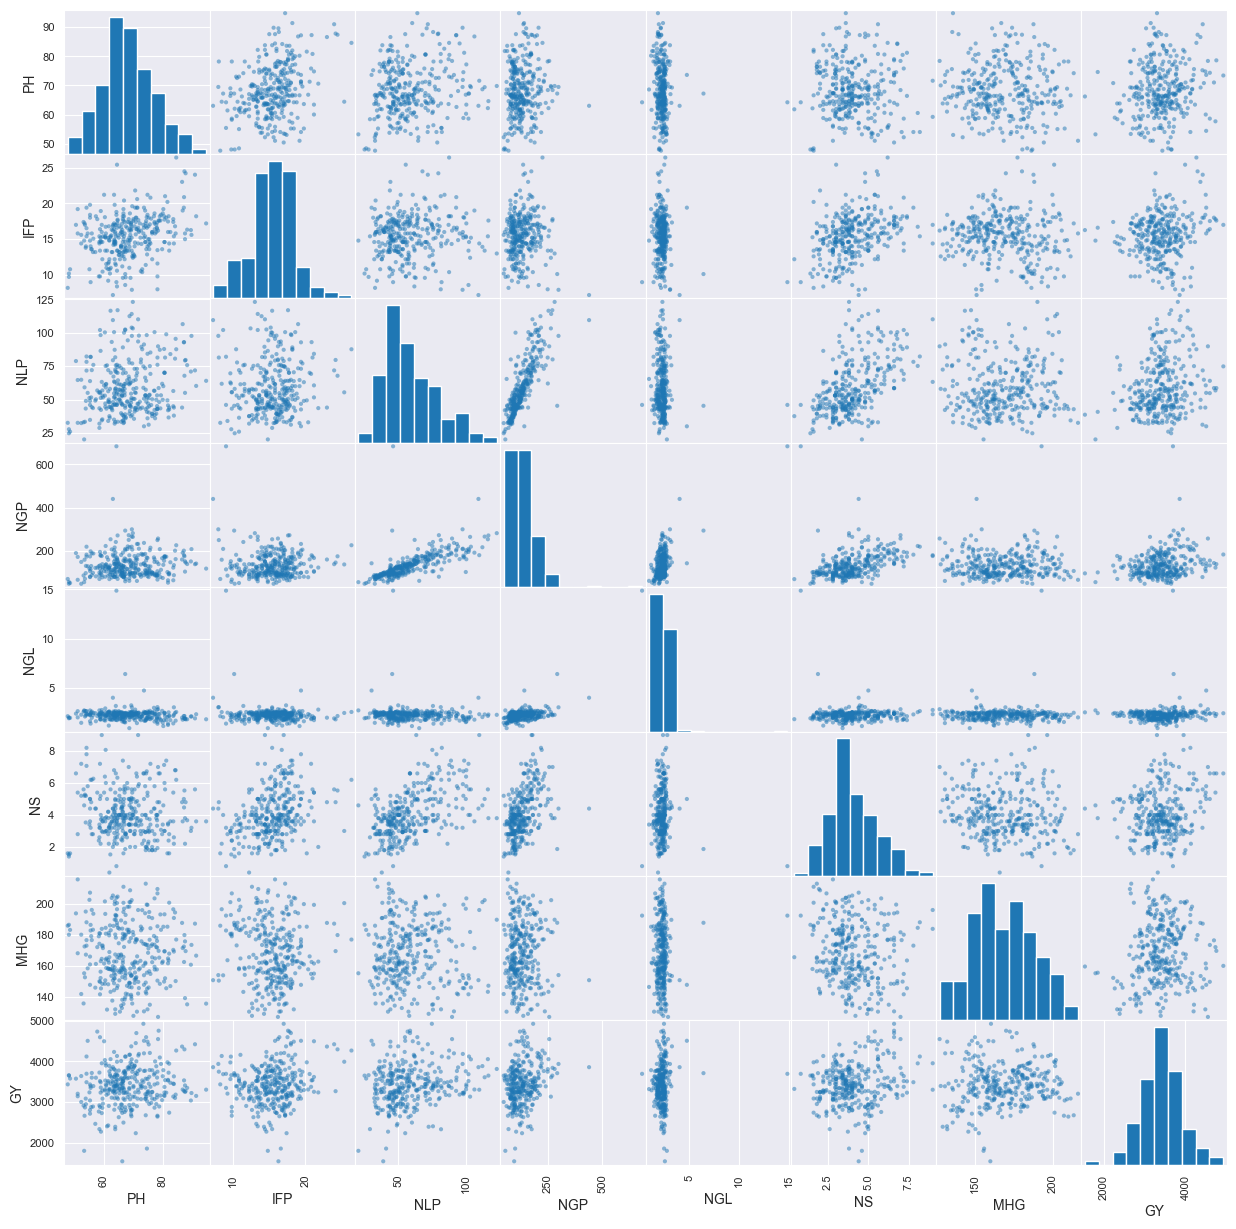

In [51]:
scatter_matrix(data[float_cols], figsize=(15,15))

As expected there is a correlation between the number of grains per plant (NGP) and number of legumes per plant (NLP) and between number of stems (NS) and number of legumes per plant (NLP).

array([[<Axes: xlabel='NGP', ylabel='NGP'>,
        <Axes: xlabel='NLP', ylabel='NGP'>,
        <Axes: xlabel='NS', ylabel='NGP'>],
       [<Axes: xlabel='NGP', ylabel='NLP'>,
        <Axes: xlabel='NLP', ylabel='NLP'>,
        <Axes: xlabel='NS', ylabel='NLP'>],
       [<Axes: xlabel='NGP', ylabel='NS'>,
        <Axes: xlabel='NLP', ylabel='NS'>,
        <Axes: xlabel='NS', ylabel='NS'>]], dtype=object)

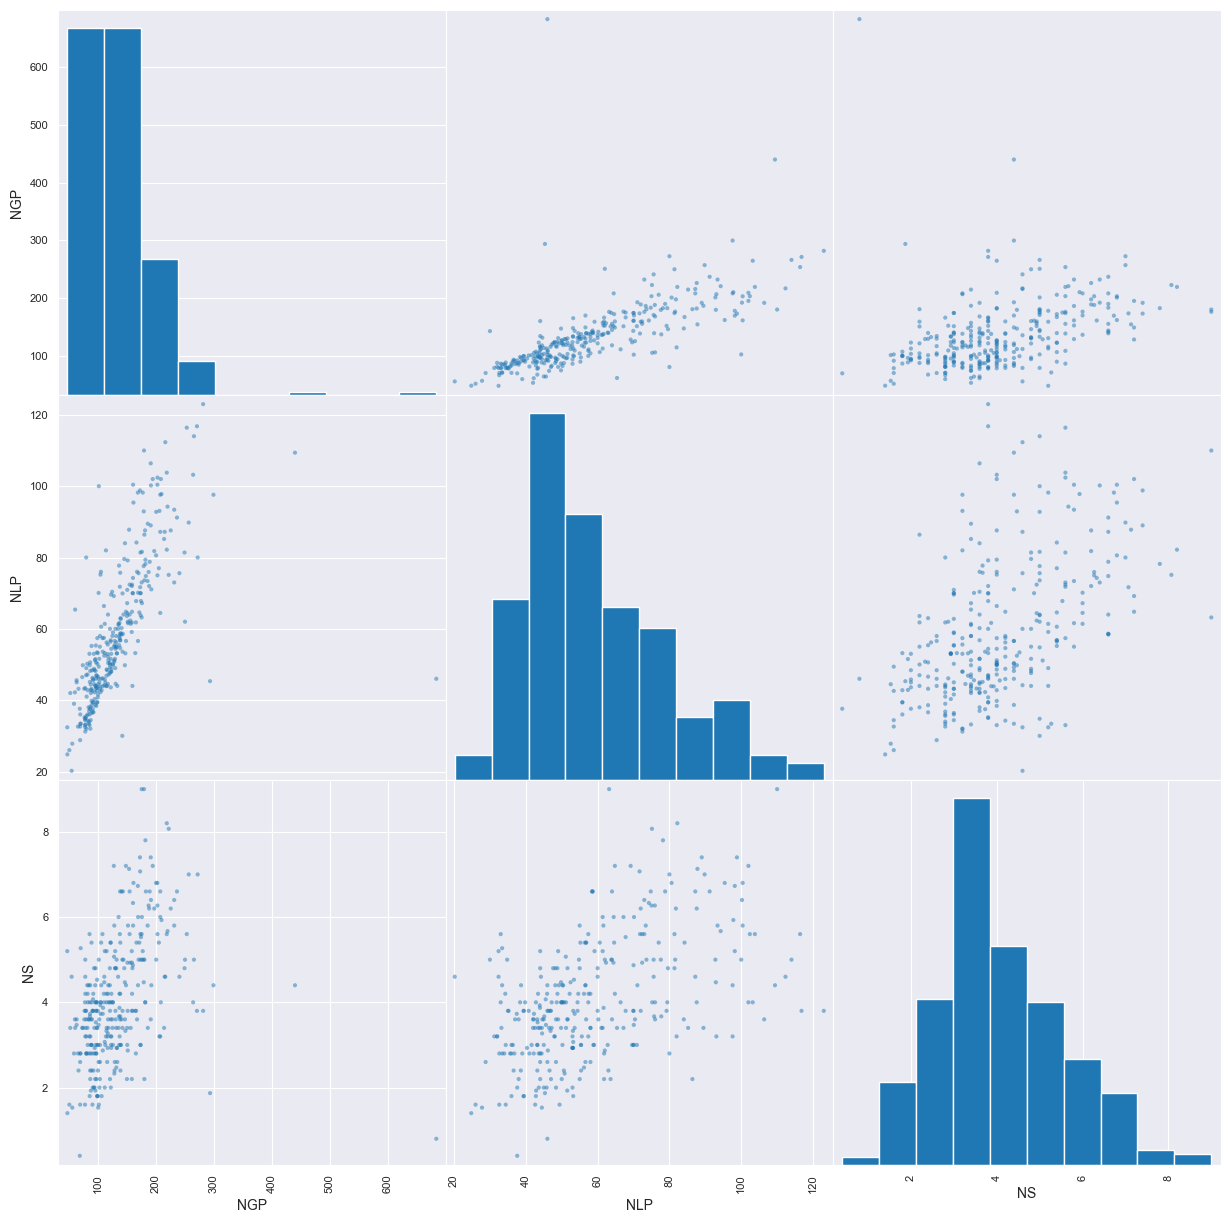

In [10]:
scatter_matrix(data[["NGP", "NLP", "NS"]], figsize=(15,15))

It's clear that there is a linear relationship between NS & NLP, NS & NGP, NGP & NLP, so we need to get more insight of these relationships. In order to find other correlations we need to remove the outliers.

In [25]:
correlation, pvalue = pearsonr(data['NLP'], data['NGP'])
print(correlation, pvalue, pvalue < 0.05)

0.8161197801611539 1.0069184152002714e-77 True


In [26]:
correlation, pvalue = pearsonr(data['NS'], data['NGP'])
print(correlation, pvalue, pvalue < 0.05)

0.5040402480780506 5.061261850067122e-22 True


In [27]:
correlation, pvalue = pearsonr(data['NS'], data['NLP'])
print(correlation, pvalue, pvalue < 0.05)

0.5281939689440748 2.172326159042103e-24 True


In [30]:
NON_MHG = [x for x in float_cols if x != '']

In [35]:
for col in NON_MHG:
    correlation, pvalue = pearsonr(data[col], data['MHG'])
    print(col, correlation, pvalue, pvalue < 0.05)


PH -0.04480857156158237 0.4243920839589844 False
IFP -0.08263715460953834 0.14021325499630322 False
NLP -0.0017089306938236218 0.975707632036019 False
NGP 0.014055882807646906 0.8022256840419104 False
NGL -0.014765058811269039 0.7924687668104496 False
NS -0.1365003733368234 0.014538079472121357 True
GY 0.0724533038033575 0.1961107855268036 False


In [36]:
for col in NON_MHG:
    correlation, pvalue = spearmanr(data[col], data['MHG'])
    print(col, correlation, pvalue, pvalue < 0.05)

PH -0.03178812459809405 0.5710123435697454 False
IFP -0.08888170539212563 0.11253881878003671 False
NLP 0.022361768953113065 0.6902587626642653 False
NGP 0.027614364263550076 0.6226192875272015 False
NGL -0.015012476104596177 0.7890722857616599 False
NS -0.15408021398081825 0.005744903848841926 True
GY 0.08096586643556554 0.14843905887960746 False


In [37]:
for col in NON_MHG:
    correlation, pvalue = kendalltau(data[col], data['MHG'])
    print(col, correlation, pvalue, pvalue < 0.05)


PH -0.02254344870316335 0.5483258783572478 False
IFP -0.05758092465903499 0.1271207829286756 False
NLP 0.021977180184338006 0.5581311747695947 False
NGP 0.019554203504621764 0.6021548167827331 False
NGL -0.012573526584747799 0.7382736245492906 False
NS -0.10348163857614275 0.006476941806326294 True
GY 0.05283788086268395 0.15864544683427595 False


In [41]:
f_classif(data[NON_MHG], data['MHG'])

(array([0.75944443, 2.03774635, 2.87480641, 1.73635529, 0.58529442,
        0.62548636, 0.35971456]),
 array([0.76572017, 0.13739994, 0.05355923, 0.20243466, 0.90437654,
        0.87568654, 0.99446824]))

In [7]:
data = clip_outliers(data)

Removing outliers exposed a strong linear correlation between NLP & NGP, NS & NGP.

In [79]:
cols = float_cols.tolist()
cols.append('Season')
pca = PCA(n_components=None)
pca.fit(data[cols])

PCA()

<Axes: >

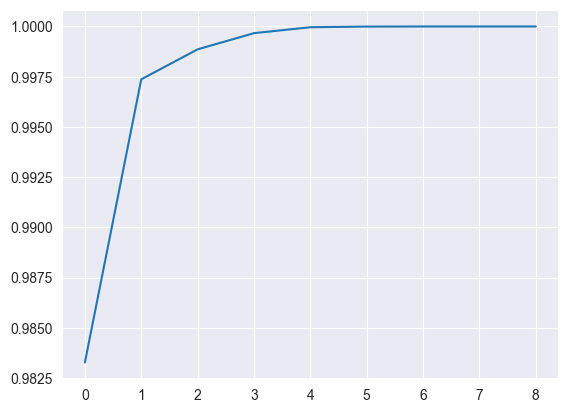

In [76]:
sns.lineplot(x = range(len(pca.explained_variance_ratio_)), y = np.cumsum(pca.explained_variance_ratio_))

In [72]:
pca.explained_variance_ratio_

array([9.83271818e-01, 1.40978651e-02, 1.49118397e-03, 8.07033463e-04,
       2.94696931e-04, 3.19660750e-05, 4.52906483e-06, 4.67542458e-07,
       4.39869387e-07])

In [97]:
new_cols = [x for x in cols if x != 'GY']

The first two components captures 99% of the overall variability.

In [98]:
pca_2 = PCA(n_components=2)
components = pca_2.fit_transform(data[new_cols])
principal_dataframe = pd.DataFrame(components, columns = ['Principal Component 1', 'Principal Component 2'])

In [99]:
pca_2.explained_variance_ratio_

array([0.85005981, 0.08495152])

In [103]:
np.corrcoef(components[:, 0], data['GY'])

array([[1.        , 0.24160019],
       [0.24160019, 1.        ]])

# Feature engineering

# Exploratory Data Analysis